# House Prices: Advanced Regression Techniques


参考：https://www.kaggle.com/jens0306/easy-prediction-using-lightgbm-model/notebook

# 读取数据

In [3]:
train_data = pd.read_csv("./input/train.csv")
test_data = pd.read_csv("./input/test.csv")
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 找了 4 个和 SalePrice 线性关系比较强的变量绘制散点图

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['STHeiti'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


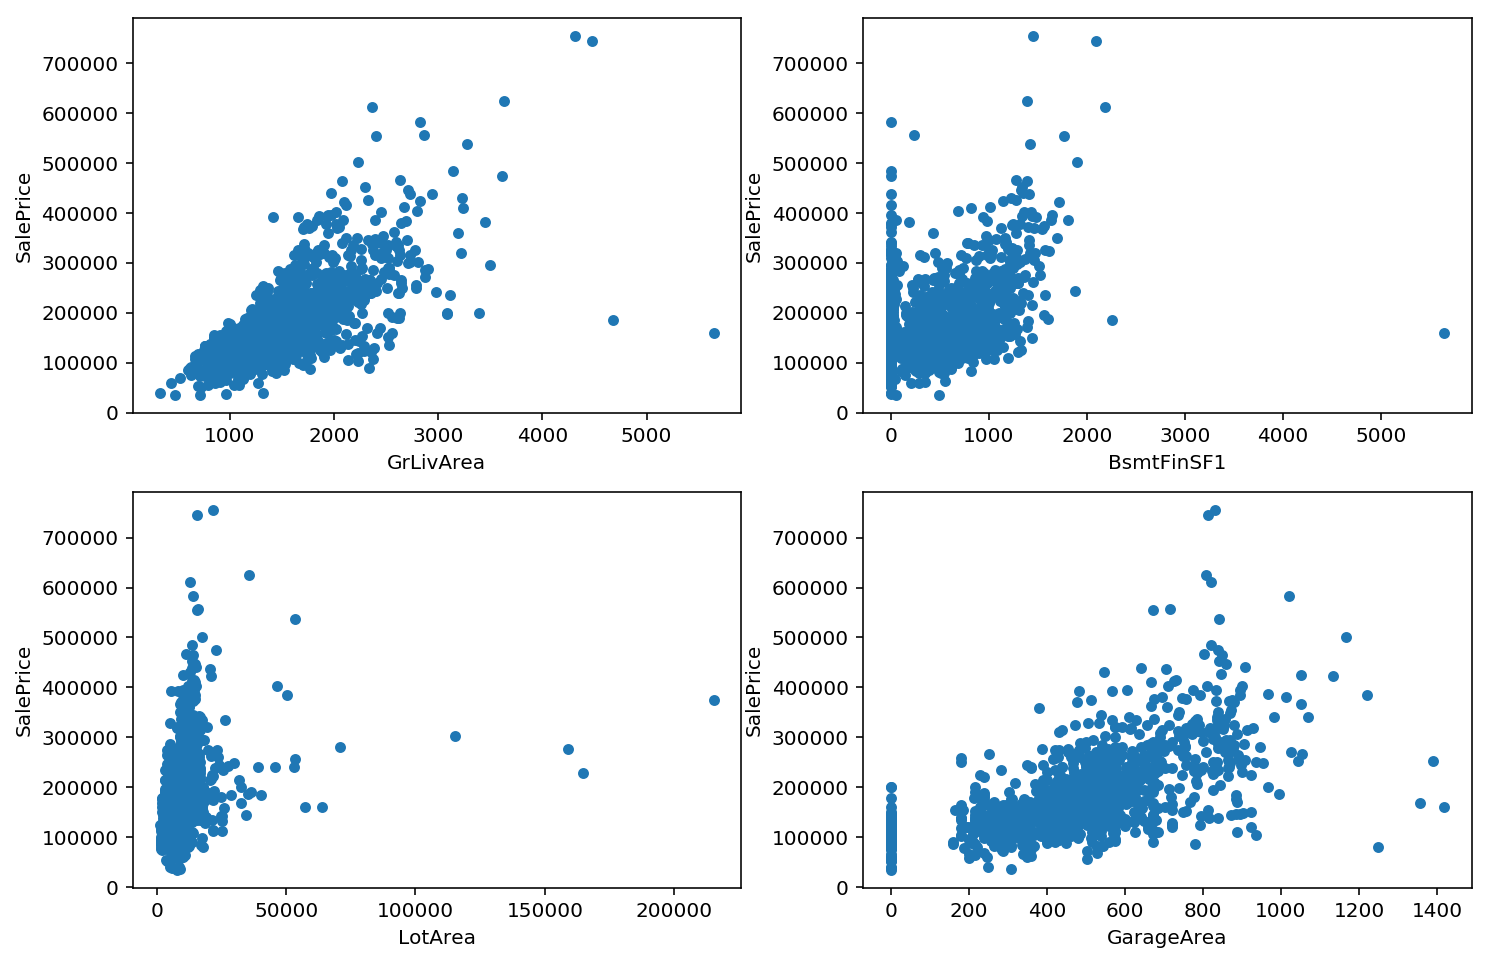

In [2]:
fig, axarr = plt.subplots(2, 2, figsize=(12, 8))
train_data.plot.scatter(x="GrLivArea", y="SalePrice", ax=axarr[0][0])
train_data.plot.scatter(x="BsmtFinSF1", y="SalePrice", ax=axarr[0][1])
train_data.plot.scatter(x="LotArea", y="SalePrice", ax=axarr[1][0])
train_data.plot.scatter(x="GarageArea", y="SalePrice", ax=axarr[1][1])
plt.show()

## 去掉离群数据

drop outliers，离群数据一整行去掉。

In [6]:
GrLivArea_SalePrice_outlier_indexes = train_data[(
    train_data['GrLivArea'] > 4000) & (train_data['SalePrice'] < 300000)].index
GrLivArea_SalePrice_outlier_indexes

Int64Index([523, 1298], dtype='int64')

In [7]:
train_data = train_data.drop(GrLivArea_SalePrice_outlier_indexes )

In [ ]:
# train_data = train_data.drop(train_data[(train_data['BsmtFinSF1'] > 3000)].index)

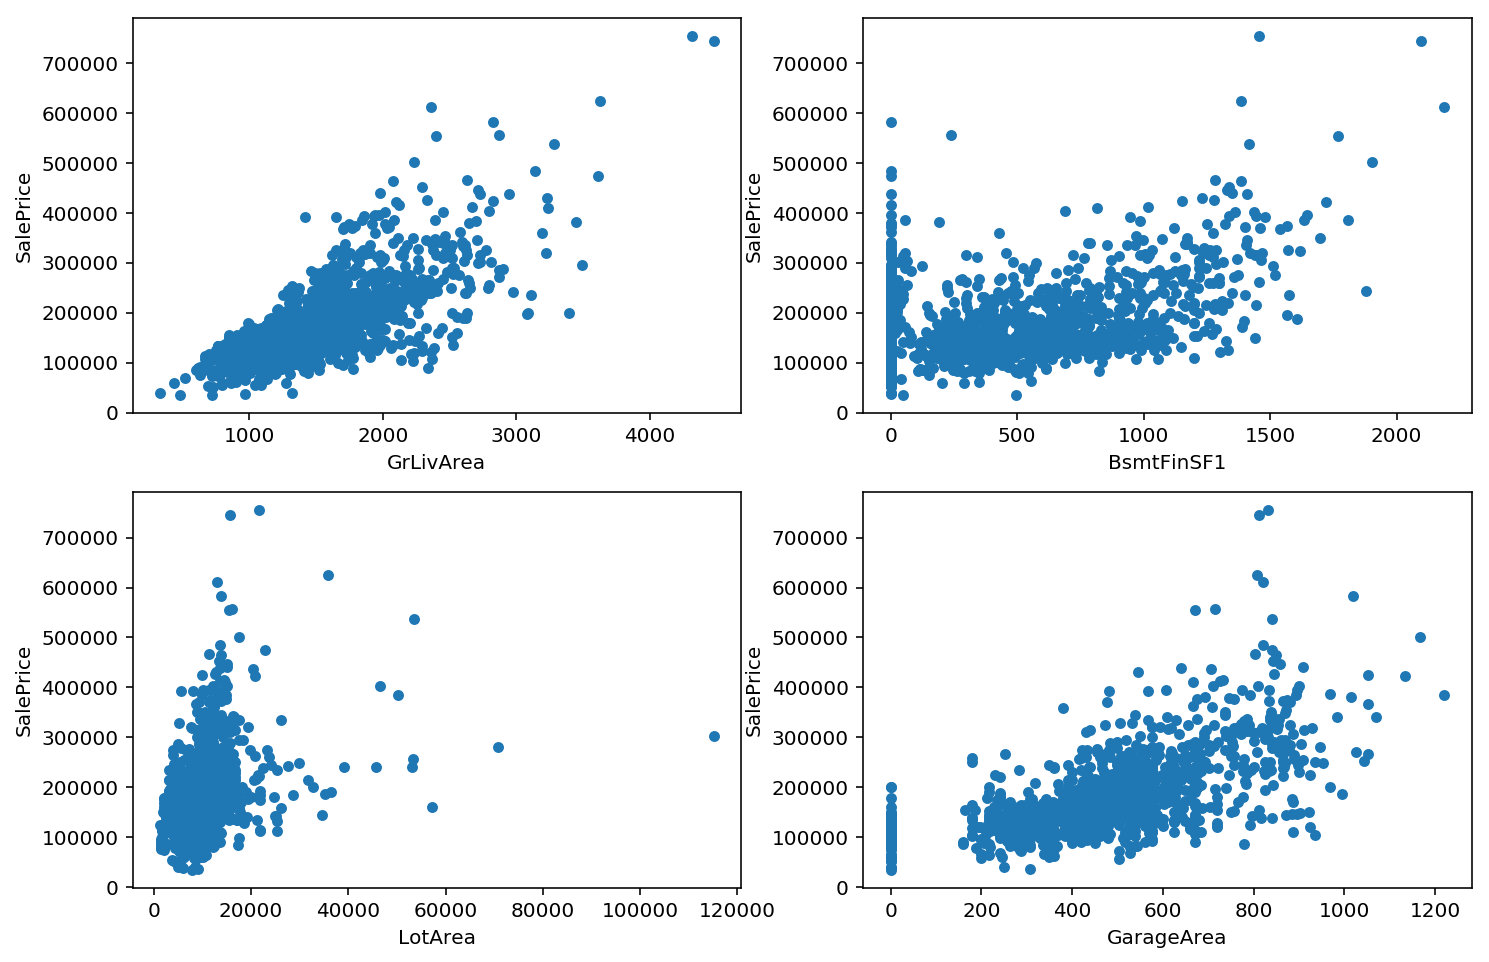

In [8]:
train_data = train_data.drop(
    train_data[(train_data['LotArea'] > 150000)].index)
train_data = train_data.drop(
    train_data[(train_data['GarageArea'] > 1200)
               & (train_data['SalePrice'] < 300000)].index)
fig, axarr = plt.subplots(2, 2, figsize=(12, 8))
train_data.plot.scatter(x="GrLivArea", y="SalePrice", ax=axarr[0][0])
train_data.plot.scatter(x="BsmtFinSF1", y="SalePrice", ax=axarr[0][1])
train_data.plot.scatter(x="LotArea", y="SalePrice", ax=axarr[1][0])
train_data.plot.scatter(x="GarageArea", y="SalePrice", ax=axarr[1][1])
plt.show()

## 把训练集和测试集合并

In [10]:
# data preprocessing
Id = test_data['Id']

In [11]:
train_y = train_data.SalePrice.values

In [16]:
# print(train_y)
all_data = pd.concat(
    (train_data, test_data), sort=False).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))
all_data.head(5)

all_data size is : (2911, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## 处理缺失值

In [17]:
# drop id
# Id 整列去掉
all_data = all_data.drop('Id', axis=1)
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [23]:
all_data.shape

(2911, 79)

In [26]:
sum(all_data.MSSubClass.isnull())

0

In [21]:
# drop NAN that missing ratio is above a certain threshold
missing_data = all_data.isnull().sum()
missing_data
# 0 表示没有空元素

MSSubClass          0
MSZoning            4
LotFrontage       483
LotArea             0
Street              0
Alley            2713
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
                 ... 
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         1
TotRmsAbvGrd        0
Functional          2
Fireplaces          0
FireplaceQu      1419
GarageType        157
GarageYrBlt       159
GarageFinish      159
GarageCars          1
GarageArea          1
GarageQual        159
GarageCond

In [22]:
missing_data == 0

MSSubClass        True
MSZoning         False
LotFrontage      False
LotArea           True
Street            True
Alley            False
LotShape          True
LandContour       True
Utilities        False
LotConfig         True
LandSlope         True
Neighborhood      True
Condition1        True
Condition2        True
BldgType          True
HouseStyle        True
OverallQual       True
OverallCond       True
YearBuilt         True
YearRemodAdd      True
RoofStyle         True
RoofMatl          True
Exterior1st      False
Exterior2nd      False
MasVnrType       False
MasVnrArea       False
ExterQual         True
ExterCond         True
Foundation        True
BsmtQual         False
                 ...  
HalfBath          True
BedroomAbvGr      True
KitchenAbvGr      True
KitchenQual      False
TotRmsAbvGrd      True
Functional       False
Fireplaces        True
FireplaceQu      False
GarageType       False
GarageYrBlt      False
GarageFinish     False
GarageCars       False
GarageArea 

In [28]:
# missing_data 整行去掉，剩下的就是有缺失值的
missing_data = missing_data.drop(missing_data[missing_data == 0].index)
# 计算缺失的百分比
missing_ratio = missing_data / len(all_data) * 100
print(missing_ratio)

MSZoning         0.137410
LotFrontage     16.592236
Alley           93.198214
Utilities        0.068705
Exterior1st      0.034352
Exterior2nd      0.034352
MasVnrType       0.824459
MasVnrArea       0.790106
BsmtQual         2.782549
BsmtCond         2.816901
BsmtExposure     2.816901
BsmtFinType1     2.713844
BsmtFinSF1       0.034352
BsmtFinType2     2.748196
BsmtFinSF2       0.034352
BsmtUnfSF        0.034352
TotalBsmtSF      0.034352
Electrical       0.034352
BsmtFullBath     0.068705
BsmtHalfBath     0.068705
KitchenQual      0.034352
Functional       0.068705
FireplaceQu     48.746135
GarageType       5.393336
GarageYrBlt      5.462041
GarageFinish     5.462041
GarageCars       0.034352
GarageArea       0.034352
GarageQual       5.462041
GarageCond       5.462041
PoolQC          99.690828
Fence           80.384748
MiscFeature     96.496049
SaleType         0.034352
dtype: float64


In [29]:
# 如果缺失大于 20% 的字段干脆丢掉
all_data = all_data.drop(missing_ratio[missing_ratio.values > 20].index, axis=1)
# all_data = all_data.drop(missing_data[missing_data.iloc[:] > 0].index, axis=1)
all_data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


## 填充缺失数值

In [33]:
# Neighborhood 是一个类别变量
# all_data['Neighborhood'] 

In [34]:
# 是一个连续型变量
all_data.groupby("Neighborhood")["LotFrontage"].mean()

Neighborhood
Blmngtn    46.900000
Blueste    27.300000
BrDale     21.500000
BrkSide    55.789474
ClearCr    88.150000
CollgCr    71.336364
Crawfor    69.951807
Edwards    65.153409
Gilbert    74.207207
IDOTRR     61.569767
MeadowV    25.606061
Mitchel    75.144444
NAmes      75.210667
NPkVill    28.142857
NWAmes     81.517647
NoRidge    91.629630
NridgHt    84.098765
OldTown    61.777293
SWISU      59.068182
Sawyer     74.551020
SawyerW    70.669811
Somerst    64.549383
StoneBr    62.173913
Timber     79.928571
Veenker    72.000000
Name: LotFrontage, dtype: float64

In [35]:
# LotFrontage has more missing value, thus we consider it more delicately
all_data["LotFrontage"] = all_data.groupby("Neighborhood")[
    "LotFrontage"].transform(lambda x: x.fillna(x.median()))

# These features are useless, drop them
all_data['Utilities'] = all_data['Utilities'].fillna(
    all_data['Utilities'].mode()[0])

# These features, we just fill them with common case
all_data['MSZoning'] = all_data['MSZoning'].fillna(
    all_data['MSZoning'].mode()[0])
all_data['Utilities'] = all_data['Utilities'].fillna(
    all_data['Utilities'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(
    all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(
    all_data['Exterior2nd'].mode()[0])
all_data['MasVnrType'] = all_data['MasVnrType'].fillna(
    all_data['MasVnrType'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(
    all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(
    all_data['KitchenQual'].mode()[0])
all_data['Functional'] = all_data['Functional'].fillna(
    all_data['Functional'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(
    all_data['SaleType'].mode()[0])

#in these features, NAN means none
all_data['BsmtQual'] = all_data['BsmtQual'].fillna('None')
all_data['BsmtCond'] = all_data['BsmtCond'].fillna('None')
all_data['BsmtExposure'] = all_data['BsmtExposure'].fillna('None')
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].fillna('None')
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].fillna('None')
all_data['GarageType'] = all_data['GarageType'].fillna('None')
all_data['GarageFinish'] = all_data['GarageFinish'].fillna('None')
all_data['GarageQual'] = all_data['GarageQual'].fillna('None')
all_data['GarageCond'] = all_data['GarageCond'].fillna('None')

#in these features, NAN means 0
all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].fillna(0)
all_data['BsmtFinSF2'] = all_data['BsmtFinSF2'].fillna(0)
all_data['BsmtUnfSF'] = all_data['BsmtUnfSF'].fillna(0)
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(0)
all_data['BsmtFullBath'] = all_data['BsmtFullBath'].fillna(0)
all_data['BsmtHalfBath'] = all_data['BsmtHalfBath'].fillna(0)
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)
all_data['GarageCars'] = all_data['GarageCars'].fillna(0)
all_data['GarageArea'] = all_data['GarageArea'].fillna(0)

# all_data = all_data.drop(missing_ratio[missing_ratio.values > 0].index, axis=1)
# missing_data = all_data.isnull().sum()
# missing_data = missing_data.drop(missing_data[missing_data == 0].index)
# missing_ratio = missing_data / len(all_data) * 100
# print(missing_ratio)
# all_data[missing_ratio.index].head(5)

在我第一次尝试时，我删除了包含缺失值的所有列。这是一种方式。下一个attemt我试着简单地用一些常用值填充它们，或者0或者None。这改善了我在另外1000场比赛中的位置！

In [37]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


## 统一处理类别变量成为独热编码

In [38]:
all_data = pd.get_dummies(all_data)
all_data.head(5)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,0,0,1,0


## 分离训练数据和测试数据

In [39]:
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
# train, test = train_test_split(all_data, test_size=0.4998)
train = all_data[:ntrain]
test = all_data[ntrain:]
train_x = train
print(train_x.shape[0], train_y.shape[0])
# train_y

1452 1452


## 交叉验证

In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Validation function
n_folds = 5


def rmsle_cv(model):
    kf = KFold(
        n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(
        model, train.values, train_y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [11]:
import lightgbm as lgb

model = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=5,
    learning_rate=0.05,
    n_estimators=720,
    max_bin=55,
    bagging_fraction=0.8,
    bagging_freq=5,
    feature_fraction=0.2319,
    feature_fraction_seed=9,
    bagging_seed=9,
    min_data_in_leaf=6,
    min_sum_hessian_in_leaf=11)
score = rmsle_cv(model)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


LGBM score: 22076.1679 (2605.5684)



In [14]:
from sklearn.metrics import mean_squared_error


def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [15]:
model.fit(train_x, train_y)
train_prediction = model.predict(train)
prediction = np.expm1(model.predict(test.values))
print(rmsle(train_y, train_prediction))
# print(prediction)

12505.043443296807


/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in expm1
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
prediction

array([inf, inf, inf, ..., inf, inf, inf])

In [16]:
submission = pd.DataFrame({'Id': Id, 'SalePrice': prediction})
submission.to_csv('submission.csv', index=False)